In [15]:
#@title mount google drive for model saving
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
#@title set up ssl
import ssl
def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

set_up_ssl()

In [17]:
#@title import packages

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.utils.prune as prune
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary
from datetime import datetime

import os
import sys
import time
import math
import argparse
import humanize
import numpy as np
import matplotlib.pyplot as plt

In [18]:
#@title Install prune tool
!git clone https://github.com/VainF/Torch-Pruning.git # recommended
!pip3 install torch_pruning

fatal: destination path 'Torch-Pruning' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
#@title global variables
# constants

term_width = 5
TOTAL_BAR_LENGTH = 7
last_time = time.time()
begin_time = last_time


In [20]:
#@title Progress bar, time conversion

def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

In [21]:
#@title BasicBlock, Bottleneck, ResNets
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        # pruning model parameters in the first convolution layer

        # prune.random_unstructured(self.conv1, name='weight', amount=0.6)
        # prune.remove(self.conv1, 'weight')

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        # pruning model parameters in the second convolution layer

        # prune.random_unstructured(self.conv2, name='weight', amount=0.6)
        # prune.remove(self.conv2, 'weight')

        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)

        # prune.random_unstructured(self.conv1, name='weight', amount=0.5)
        # prune.remove(self.conv1, 'weight')

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        
        # prune.random_unstructured(self.conv2, name='weight', amount=0.5)
        # prune.remove(self.conv2, 'weight')

        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        
        # prune.random_unstructured(self.conv3, name='weight', amount=0.5)
        # prune.remove(self.conv3, 'weight')

        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        
        # prune.random_unstructured(self.conv1, name='weight', amount=0.5)
        # prune.remove(self.conv1, 'weight')

        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # removing the 4th layer to reduce the size of the network
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

        # prune.random_unstructured(self.linear, name='weight', amount=0.5)
        # prune.remove(self.linear, 'weight')

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # removing the 4th layer to reduce the size of the network
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


In [22]:
#@title Set device
LOCAL_M1 = False

if LOCAL_M1:
    device = 'cuda' if torch.cuda.is_available() else 'mps'
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [23]:
#@title Pruning
import torch_pruning as tp

def prune_model(model):
    model.cpu()
    DG = tp.DependencyGraph().build_dependency( model, torch.randn(1, 3, 32, 32) )
    def prune_conv(conv, amount=0.2):
        strategy = tp.strategy.L1Strategy()
        pruning_index = strategy(conv.weight, amount=amount)
        plan = DG.get_pruning_plan(conv, tp.prune_conv_out_channel, pruning_index)
        plan.exec()
    
    block_prune_probs = [0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3]
    blk_id = 0
    for m in model.modules():
        if isinstance( m, BasicBlock):
            prune_conv( m.conv1, block_prune_probs[blk_id] )
            prune_conv( m.conv2, block_prune_probs[blk_id] )
            blk_id+=1
    return model   

In [24]:
#@title Count params before and after pruning

def count_parameters(model):
    sum_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return humanize.intword(sum_params)
    

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
The length of a train set is  45000
The length of a validation set is  5000
The length of a test set is  10000
The number of parameters before pruning is  11.2 million
The number of parameters after pruning is  4.5 million
The total number of parameters before the training is  4.5 million

Epoch: 0
 [======>]  Step: 49ms | Tot: 46s516ms | Train Loss: 1.764 | Train Acc: 34.896% (15703/45000) 352/352 
 [======>]  Step: 14ms | Tot: 3s258ms | Valid Loss: 1.598 | Valid Acc: 42.200% (2110/5000) 40/40 
Saving..

Epoch: 1
 [======>]  Step: 47ms | Tot: 37s903ms | Train Loss: 1.264 | Train Acc: 54.751% (24638/45000) 352/352 
 [======>]  Step: 11ms | Tot: 3s199ms | Valid Loss: 1.458 | Valid Acc: 50.720% (2536/5000) 40/40 
Saving..

Epoch: 2
 [======>]  Step: 49ms | Tot: 38s744ms | Train Loss: 1.032 | Train Acc: 63.458% (28556/45000) 352/352 
 [======>]  Step: 14ms | Tot: 3s312ms | 

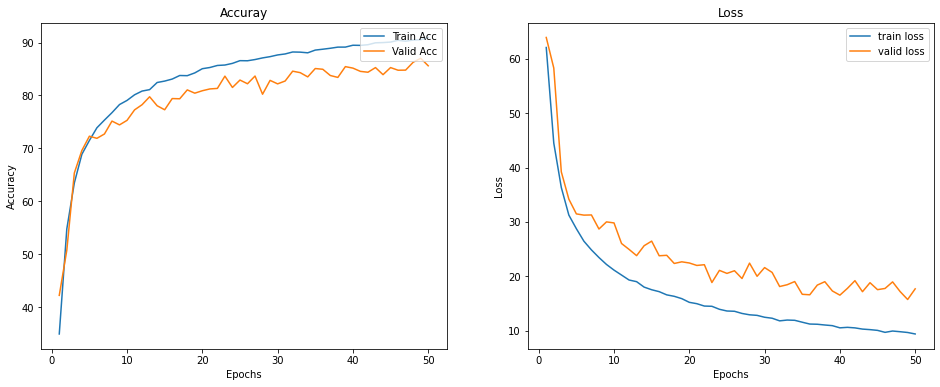

In [25]:
#@title  iterate scheduler and train

i=0

# Prepare data

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #transforms.RandomErasing()
  
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

torch.manual_seed(42)
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])

print("The length of a train set is ", len(train_ds))
print("The length of a validation set is ", len(val_ds))
print("The length of a test set is ", len(testset))

trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=128, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=128, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

net = ResNet18() # 11.2 params
#net = ResNet50() # 23.5


# print parameters  before and after pruning
print("The number of parameters before pruning is ", count_parameters(net))

prune_model(net)

print("The number of parameters after pruning is ", count_parameters(net))

print("The total number of parameters before the training is ", count_parameters(net))

train_acc_array, train_loss_array = [], [] # for plotting
val_acc_array, val_loss_array = [], [] # for plotting

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

#@title Training
def train(epoch):
  print('\nEpoch: %d' % epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  train_acc = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

      train_acc=100.*correct/total
      progress_bar(batch_idx, len(trainloader), 'Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                    % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

  train_acc_array.append(train_acc) # for plottting
  train_loss_array.append(train_loss) # for plottting

#@title Validation and save best model
def evaluate(epoch): 
  
    global best_acc
    net.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
          
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(val_loader), 'Valid Loss: %.3f | Valid Acc: %.3f%% (%d/%d)'
                        % (valid_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    valid_acc = 100.*correct/total
    if valid_acc > best_acc:
        print('Saving..')
        state = {
            'net_state_dict': net.state_dict(),
            'acc': valid_acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = valid_acc
    val_acc_array.append(valid_acc) # for plottting
    val_loss_array.append(valid_loss) # for plottting

#@title Load the best model parameters and test
def test(): 
  
    test_loss = 0
    correct = 0
    total = 0
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net_state_dict'])
    best_epoch = checkpoint['epoch']
    best_acc = checkpoint['acc']
    net.eval()
    print(f'Best validation acc: {best_acc:.3f}% at Epoch {best_epoch}')
    with torch.no_grad():
          
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs) 
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(test_loader), 'Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                        % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

#@title Plotting



lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
schedulers = [
  lr_scheduler.CosineAnnealingLR(optimizer, T_max=200),
  lr_scheduler.StepLR(optimizer, step_size=5),
  lr_scheduler.MultiStepLR(optimizer, milestones=[30,80]),
  lr_scheduler.LinearLR(optimizer),
  lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, mode='triangular2'),
]
scheduler = schedulers[i]

#@title Train, validate, test

NUM_EPOCHS = 50

for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    train(epoch)
    evaluate(epoch)
    scheduler.step()

print('---------------------------------------- Testing Model... ----------------------------------------')
test()
print('Number of parameters after training', count_parameters(net))


fig = plt.figure(figsize=(16,6))

plt.subplot(121)
plt.plot(np.arange(1,NUM_EPOCHS+1),train_acc_array)
plt.plot(np.arange(1,NUM_EPOCHS+1),val_acc_array)
plt.title("Accuray")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Acc","Valid Acc"],loc = "upper right")

train_loss_array = [i / 10 for i in train_loss_array]
plt.subplot(122)
plt.plot(np.arange(1,NUM_EPOCHS+1,dtype=int),train_loss_array)
plt.plot(np.arange(1,NUM_EPOCHS+1,dtype=int),val_loss_array)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'valid loss'], loc="upper right")
plt.savefig(f'scheduler_{i}')


  

In [26]:
#@title Prepare data

# best_acc = 0  # best test accuracy
# start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# # Data
# print('==> Preparing data..')
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32, padding=4),
#     transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#     #transforms.RandomErasing()
  
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# # constructing validation set

# trainset = torchvision.datasets.CIFAR10(
#     root='./data', train=True, download=True, transform=transform_train)

# testset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, download=True, transform=transform_test)

# torch.manual_seed(42)
# val_size = 5000
# train_size = len(trainset) - val_size

# train_ds, val_ds = random_split(trainset, [train_size, val_size])

# print("The length of a train set is ", len(train_ds))
# print("The length of a validation set is ", len(val_ds))
# print("The length of a test set is ", len(testset))

# trainloader = torch.utils.data.DataLoader(
#     train_ds, batch_size=128, shuffle=True, num_workers=2)

# val_loader = torch.utils.data.DataLoader(
#     val_ds, batch_size=128, shuffle=True, num_workers=2)

# testl_oader = torch.utils.data.DataLoader(
#     testset, batch_size=128, shuffle=True, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck')

# net = ResNet18() # 11.2 params
# #net = ResNet50() # 23.5

In [27]:
# layers = list(net.children())

# print(len(layers))

# print("layers[0]: ", layers[0])
# print("layers[1]: ", layers[1])
# print("layers[2]: ", layers[2])
# print("layers[3]: ", layers[3])
# print("layers[4]: ", layers[4])
# print("layers[5]: ", layers[5])
# print("layers[6]: ", layers[6])

In [28]:
# from torchpruner import (Pruner, ShapleyAttributionMetric)

In [29]:
def get_pruned_parameters_countget_pruned_parameters_count(pruned_model):
    params = 0
    for param in pruned_model.parameters():
        if param is not None:
            params += torch.nonzero(param).size(0)
    return params

In [30]:
from torchsummary import summary

def print_model_summary(model):
  print(summary(model.to(device), (3, 32, 32)))

#print_model_summary(net)

In [31]:
def print_model_layers(model):
  for name, param in model.named_parameters():
    print(name, param.size())

#print_model_layers(net)

In [32]:
def freeze_layer(layer_name):
  for param_name, param in net.named_parameters():
    if layer_name in param_name:
      param.requires_grad = False

In [33]:
# freeze_layer("layer3")

In [34]:
#print_model_summary(net)